# All-Weather Maritime Asset Identification (YOLOv8)

This self-contained notebook:
- **Acquires & curates** a maritime vessel dataset into **`clear_weather/`** vs **`adverse_weather/`** (with fallbacks and synthetic drift if needed).
- **Fine-tunes YOLOv8n** on **clear** only, then **evaluates on clear vs adverse** to **quantify data drift**.
- Builds a **Streamlit inference app** to visualize detections & confidence behavior across conditions.
- Saves compliance & governance artifacts (metrics JSON/CSV, plots, degradation report, model card) under `artifacts/`.

> Blue Lane = low-code defaults; Red Lane = optional deeper training/experiments.


In [1]:
# --- Bootstrap & Environment --------------------------------------------------
import os, sys, random, json, time, pathlib, platform, shutil, subprocess, re, socket
from pathlib import Path
import numpy as np

print("Python  :", platform.python_version())
print("OS      :", platform.platform())
print("CPU     :", platform.processor())
try:
    import torch
    HAS_TORCH = True
    print("Torch   :", torch.__version__)
    print("CUDA    :", torch.cuda.is_available())
except Exception as e:
    HAS_TORCH = False
    print("Torch   : not installed")

# Deterministic seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
if HAS_TORCH:
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Create folders
for d in ["data", "data/maritime", "models", "artifacts", "artifacts/plots", "app", "hf_cache", "runs"]:
    Path(d).mkdir(parents=True, exist_ok=True)

# Flags
BLUE_LANE = True
SKIP_HEAVY_TRAINING = False  # keep runtime short by default

# Offline detection
OFFLINE = False
try:
    socket.create_connection(("www.google.com", 80), timeout=3)
except Exception:
    OFFLINE = True
print("OFFLINE :", OFFLINE)

# (Optional) HF cache for any supporting components
os.environ["TRANSFORMERS_CACHE"] = str(Path("hf_cache").resolve())

# Initialize model card with a data-use note placeholder
model_card = Path("artifacts/model_card.md")
if not model_card.exists():
    model_card.write_text(
        "# Model Card (WIP)\n\n"
        "## Data Use & License\n"
        "- Source: Singapore Maritime dataset (Kaggle) if available; otherwise tiny mirrored/synthetic subset.\n"
        "- Images are for educational experimentation; **no classified imagery**.\n"
        "## Notes\n"
        "- This file will be appended with training/eval details and drift findings.\n",
        encoding="utf-8"
    )
print("Created artifacts/model_card.md")


Python  : 3.11.13
OS      : Windows-10-10.0.26200-SP0
CPU     : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
Torch   : 2.9.0+cpu
CUDA    : False
OFFLINE : False
Created artifacts/model_card.md


In [2]:
# Create venv with Python 3.11 (no 'py' launcher needed)
import os, sys, subprocess, shutil, platform, pathlib

def find_py311():
    # 1) Prefer env var override
    for env_var in ["PYTHON311", "P311", "PY311"]:
        p = os.environ.get(env_var)
        if p and pathlib.Path(p).exists():
            return p
    # 2) If current interpreter is 3.111, use it
    if sys.version_info[:2] == (3, 11):  # fixed
        return sys.executable
    # 3) Try common Windows install paths
    candidates = [
        r"C:\Users\%USERNAME%\AppData\Local\Programs\Python\Python311\python.exe",
        r"C:\Program Files\Python311\python.exe",
        r"C:\Program Files (x86)\Python311\python.exe",
    ]
    candidates = [os.path.expandvars(p) for p in candidates]
    for p in candidates:
        if pathlib.Path(p).exists():
            return p
    # 4) Try anything named python3.11 on PATH
    p = shutil.which("python3.11") or shutil.which("python311")
    if p:
        return p
    return None

py311 = find_py311()
if not py311:
    print("[ERROR] Could not find Python 3.11 on this system.")
    print("Install it, then re-run this cell. From VS Code PowerShell:")
    print('  winget install -e --id Python.Python.3.11')
else:
    print("Using Python 3.11 at:", py311)
    # Create venv
    subprocess.check_call([py311, "-m", "venv", ".venv311"])
    # Upgrade pip and ensure ipykernel in the venv
    subprocess.check_call([r".\.venv311\Scripts\python", "-m", "pip", "install", "-U", "pip", "setuptools", "wheel"])
    subprocess.check_call([r".\.venv311\Scripts\python", "-m", "pip", "install", "ipykernel"])
    # Register Jupyter kernel
    subprocess.check_call([r".\.venv311\Scripts\python", "-m", "ipykernel", "install",
                           "--user", "--name", "sitrep311", "--display-name", "Python 3.11 (sitrep)"])
    print("Now switch the Notebook kernel to: Python 3.11 (sitrep)")

Using Python 3.11 at: c:\Users\tcmk_\Downloads\elice notebooks\.venv311\Scripts\python.exe
Now switch the Notebook kernel to: Python 3.11 (sitrep)


In [16]:
# --- Install Packages (graceful) ----------------------------------------------
def pip_install(pkgs):
    for p in pkgs:
        try:
            print(f"Installing {p} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])
        except Exception as e:
            print(f"[WARN] Could not install {p}: {e}")

required = [
    "ultralytics",      # YOLOv8
    "torch",            # may already be present in platform
    "opencv-python",
    "numpy",
    "pandas",
    "pyyaml",
    "streamlit",
    "matplotlib",
    "seaborn",
    "tabulate",
]
pip_install(required)


Installing ultralytics ...
Installing torch ...
Installing opencv-python ...
Installing numpy ...
Installing pandas ...
Installing pyyaml ...
Installing streamlit ...
Installing matplotlib ...
Installing seaborn ...
Installing tabulate ...


## SPEC-DRIVE Card (Fill Me)

- **Operational Requirement:** *(e.g., mAP≥0.80 clear; mAP≥0.60 adverse)*
- **Input Data:** *(Ship images + YOLO labels)*
- **Success Metrics:** *(mAP@0.5 and mAP@0.5:0.95, precision, recall)*
- **Environmental Constraints:** *(Haze/rain/low-light; no classified imagery)*
- **V&V Goal:** *(Quantify performance degradation; report % drop)*
- **Rollback Plan:** *(Augmentations, mixed-weather retraining, TTA)*


In [3]:
# --- Save SPEC-DRIVE to artifacts/spec_drive.md -------------------------------
SPEC_CARD = """
Operational Requirement: <edit me>
Input Data: Ship images + YOLO labels
Success Metrics: mAP@0.5 and mAP@0.5:0.95, precision, recall
Environmental Constraints: Haze/rain/low-light; no classified imagery
V&V Goal: Quantify performance degradation; report %% drop
Rollback Plan: Augmentations; mixed-weather retraining; TTA
"""
Path("artifacts/spec_drive.md").write_text(SPEC_CARD.strip()+"\n", encoding="utf-8")
print("Saved artifacts/spec_drive.md")


Saved artifacts/spec_drive.md


In [ ]:
# --- Frame Extraction Logic (updated to match actual dataset names) ------------
import cv2
import glob
from pathlib import Path

def extract_frames(video_path, output_dir, frame_skip=None):
    """
    Extract frames from a video.
    - If FPS is available, save ~1 frame per second.
    - Otherwise, default to every 30 frames.
    """
    video_name = Path(video_path).stem
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[WARN] Could not open video file: {video_path}")
        return

    # Derive a sensible skip if not provided (≈1 FPS)
    if frame_skip is None:
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_skip = int(fps) if fps and fps > 0 else 30

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    frame_count = 0
    saved_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video
        if frame_count % frame_skip == 0:
            output_filename = f"{video_name}_frame_{saved_count:04d}.jpg"
            cv2.imwrite(str(output_dir / output_filename), frame)
            saved_count += 1
        frame_count += 1

    cap.release()
    print(f"-> Extracted {saved_count:4d} frames from {Path(video_path).name} into {output_dir}")

def process_all_videos(raw_data_path, root_output_path):
    """
    Walk all .avi files and:
      - Clear (train/val): VIS_Onshore videos WITHOUT 'Haze' in filename.
      - Adverse (test): any NIR videos, any VIS_Onboard videos, and any filename containing 'Haze'.
    Clear train/val are assigned by alternating files deterministically.
    """
    print("--- Starting Frame Extraction ---")
    raw_data_path = Path(raw_data_path)
    root_output_path = Path(root_output_path)

    video_files = sorted(glob.glob(str(raw_data_path / "**/*.avi"), recursive=True))
    if not video_files:
        print("[INFO] No .avi video files found in the raw data directory.")
        return False

    clear_counter = 0
    processed_any = False

    for vf in video_files:
        p = Path(vf)
        path_lower = str(p.parent).lower()
        name_lower = p.name.lower()

        is_haze = "haze" in name_lower
        is_nir = "nir" in path_lower or name_lower.endswith("_nir.avi") or "_nir_" in name_lower
        is_vis_onboard = "vis_onboard" in path_lower or "_vis_ob" in name_lower
        is_vis_onshore = "vis_onshore" in path_lower or "_vis" in name_lower

        # Decide condition/split
        if is_haze or is_nir or is_vis_onboard:
            condition = "adverse_weather"
            split = "test"
        elif is_vis_onshore and not is_haze:
            condition = "clear_weather"
            split = "train" if (clear_counter % 2 == 0) else "val"
            clear_counter += 1
        else:
            # If we can't confidently classify, skip
            print(f"[INFO] Skipping (no rule matched): {p.name}")
            continue

        out_dir = root_output_path / condition / "images" / split
        extract_frames(str(p), str(out_dir))
        processed_any = True

    print("--- Frame Extraction Complete ---")
    return processed_any


In [12]:
# --- Data Acquisition & Curation ---------------------------------------------
import os, json, shutil, zipfile, random, glob
from pathlib import Path
import numpy as np
import cv2

root = Path("data/maritime")
# Desired structure:
# data/maritime/
#   clear_weather/images/{train,val}
#   clear_weather/labels/{train,val}
#   adverse_weather/images/test
#   adverse_weather/labels/test

def make_dirs():
    for p in [
        root/"clear_weather/images/train",
        root/"clear_weather/images/val",
        root/"clear_weather/labels/train",
        root/"clear_weather/labels/val",
        root/"adverse_weather/images/test",
        root/"adverse_weather/labels/test",
    ]:
        p.mkdir(parents=True, exist_ok=True)

make_dirs()

# Reuse extract_frames/process_all_videos from the previous cell.

# --- Synthetic Data Generation (Fallback) ---
def write_yolo_label(label_path: Path, boxes, cls=0):
    label_lines = []
    for (x1,y1,x2,y2) in boxes:
        w = max(1, x2-x1); h = max(1, y2-y1)
        xc = x1 + w/2; yc = y1 + h/2
        label_lines.append((cls, xc, yc, w, h))
    label_path.parent.mkdir(parents=True, exist_ok=True)
    return label_lines

def save_yolo_label(label_path: Path, label_lines, img_w, img_h):
    with open(label_path, "w") as f:
        for cls, xc, yc, w, h in label_lines:
            f.write(f"{cls} {xc/img_w:.6f} {yc/img_h:.6f} {w/img_w:.6f} {h/img_h:.6f}\n")

def synth_ship_image(w=640, h=384, n_boxes=1, adverse=False):
    img = np.zeros((h,w,3), dtype=np.uint8)
    img[:h//2] = (200, 220, 255); img[h//2:] = (180, 160, 120)
    boxes = []
    for _ in range(n_boxes):
        bw = random.randint(40, 120); bh = random.randint(20, 60)
        x1 = random.randint(10, w-bw-10); y1 = random.randint(h//2+10, h-bh-10)
        x2 = x1 + bw; y2 = y1 + bh
        color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
        cv2.rectangle(img, (x1,y1), (x2,y2), color, -1)
        cv2.line(img, (x1+bw//2,y1), (x1+bw//2,y1-15), (50,50,50), 3)
        boxes.append((x1,y1,x2,y2))
    if adverse:
        img = cv2.GaussianBlur(img, (11,11), 0)
        img = (img * 0.6).astype(np.uint8)
        noise = np.random.normal(0, 12, img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        for _ in range(200):
            x = random.randint(0, w-1); y = random.randint(0, h-1)
            length = random.randint(5,15)
            cv2.line(img, (x,y), (min(w-1, x+2), min(h-1, y+length)), (200,200,200), 1)
    return img, boxes

def populate_clear_synth(n_train=16, n_val=8):
    for i in range(n_train):
        img, boxes = synth_ship_image(n_boxes=random.randint(1,3), adverse=False)
        img_path = root/f"clear_weather/images/train/clear_train_{i}.jpg"
        lab_path = root/f"clear_weather/labels/train/clear_train_{i}.txt"
        cv2.imwrite(str(img_path), img)
        lines = write_yolo_label(lab_path, boxes); save_yolo_label(lab_path, lines, img.shape[1], img.shape[0])
    for i in range(n_val):
        img, boxes = synth_ship_image(n_boxes=random.randint(1,3), adverse=False)
        img_path = root/f"clear_weather/images/val/clear_val_{i}.jpg"
        lab_path = root/f"clear_weather/labels/val/clear_val_{i}.txt"
        cv2.imwrite(str(img_path), img)
        lines = write_yolo_label(lab_path, boxes); save_yolo_label(lab_path, lines, img.shape[1], img.shape[0])

def populate_adverse_synth(n_adv=12):
    for i in range(n_adv):
        img, boxes = synth_ship_image(n_boxes=random.randint(1,3), adverse=True)
        img_path = root/f"adverse_weather/images/test/adverse_test_{i}.jpg"
        lab_path = root/f"adverse_weather/labels/test/adverse_test_{i}.txt"
        cv2.imwrite(str(img_path), img)
        lines = write_yolo_label(lab_path, boxes); save_yolo_label(lab_path, lines, img.shape[1], img.shape[0])

# --- Main Logic Flow (Revised) ---
kaggle_ok = False
force_kaggle = os.getenv("FORCE_KAGGLE", "0") == "1"
raw_data_dir = root / "raw" / "singapore-maritime-dataset"

try:
    if OFFLINE:
        print("Offline; skipping Kaggle download.")
    elif raw_data_dir.exists() and any(raw_data_dir.iterdir()) and not force_kaggle:
        print("Kaggle dataset already exists; skipping download.")
        kaggle_ok = True
    else:
        try:
            import opendatasets as od
        except ImportError:
            print("Installing opendatasets...")
            import sys, subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", "opendatasets", "--quiet"])
            import opendatasets as od
        kaggle_url = "https://www.kaggle.com/datasets/mmichelli/singapore-maritime-dataset"
        print("Attempting Kaggle download via opendatasets...")
        od.download(kaggle_url, data_dir=str(root / "raw"))
        kaggle_ok = True
except Exception as e:
    print(f"[WARN] Kaggle/opendatasets download failed: {e}")


# Process videos only if frames are missing (idempotent). Force with FORCE_REEXTRACT=1
def any_images(p: Path) -> bool:
    return p.exists() and any(p.glob("*.jpg"))

def dataset_has_clear_images() -> bool:
    return any_images(root / "clear_weather/images/train") or any_images(root / "clear_weather/images/val")

def dataset_has_adverse_images() -> bool:
    return any_images(root / "adverse_weather/images/test")

def has_any_extracted_frames() -> bool:
    return dataset_has_clear_images() or dataset_has_adverse_images()

FORCE_REEXTRACT = os.getenv("FORCE_REEXTRACT", "0") == "1"

if raw_data_dir.exists():
    if has_any_extracted_frames() and not FORCE_REEXTRACT:
        print("[INFO] Existing extracted frames detected; skipping re-extraction. Set FORCE_REEXTRACT=1 to force.")
    else:
        processed = process_all_videos(raw_data_dir, root)
        if not processed:
            print("[INFO] No .avi videos processed from raw dataset.")


# Fill missing splits with synthetic data (do not overwrite real)
if not dataset_has_clear_images():
    print("\n[INFO] Clear images not found. Creating synthetic clear train/val.")
    populate_clear_synth()

if not dataset_has_adverse_images():
    print("\n[INFO] Adverse images not found. Creating synthetic adverse test.")
    populate_adverse_synth()


# --- Pseudo-label real frames with a pretrained YOLO (COCO 'boat' -> 'ship') ---
def pseudo_label_dir(img_dir: Path, lbl_dir: Path, conf=0.25, overwrite=False, device=None):
    """
    Writes YOLO labels for images in img_dir into lbl_dir using a pretrained model.
    Keeps only COCO 'boat' (and 'ship' if present) and remaps to single class 0.
    """
    try:
        from ultralytics import YOLO
    except Exception as e:
        print("[WARN] ultralytics not available for pseudo-labeling:", e)
        return 0

    model = YOLO("yolov8n.pt")  # COCO-pretrained
    names = getattr(model.model, "names", getattr(model, "names", {}))
    name_items = names.items() if isinstance(names, dict) else enumerate(names)
    boat_idxs = {i for i, n in name_items if str(n).lower() in {"boat", "ship"}}
    if not boat_idxs:
        boat_idxs = {8}  # fallback: COCO 'boat' idx

    img_dir = Path(img_dir); lbl_dir = Path(lbl_dir)
    lbl_dir.mkdir(parents=True, exist_ok=True)

    import glob as _glob
    created = 0
    files = sorted(_glob.glob(str(img_dir/"*.jpg"))) + sorted(_glob.glob(str(img_dir/"*.png")))
    for p in files:
        p = Path(p)
        y = lbl_dir / (p.stem + ".txt")
        if (not overwrite) and y.exists() and y.stat().st_size > 0:
            continue
        try:
            res = model.predict(source=str(p), imgsz=640, conf=conf, verbose=False, device=device)
            if not len(res):
                continue
            r = res[0]
            h, w = r.orig_shape[:2]
            lines = []
            for b in getattr(r, "boxes", []):
                cls = int(b.cls[0].item()) if hasattr(b, "cls") else -1
                if cls not in boat_idxs:
                    continue
                x1, y1, x2, y2 = b.xyxy[0].cpu().numpy().tolist()
                bw = max(1.0, x2 - x1); bh = max(1.0, y2 - y1)
                xc = x1 + bw / 2.0; yc = y1 + bh / 2.0
                lines.append(f"0 {xc/w:.6f} {yc/h:.6f} {bw/w:.6f} {bh/h:.6f}")
            if lines:
                y.write_text("\n".join(lines) + "\n", encoding="utf-8")
                created += 1
        except Exception as e:
            print(f"[WARN] pseudo-label failed for {p.name}: {e}")
    print(f"[INFO] Pseudo-labeled {created} images in {img_dir}")
    return created

# Apply pseudo-labeling where labels are missing/empty (Kaggle frames)
pseudo_label_dir(root/"clear_weather/images/train", root/"clear_weather/labels/train", conf=0.25, overwrite=False)
pseudo_label_dir(root/"clear_weather/images/val",   root/"clear_weather/labels/val",   conf=0.25, overwrite=False)
pseudo_label_dir(root/"adverse_weather/images/test",root/"adverse_weather/labels/test", conf=0.25, overwrite=False)

# If clear train+val still have zero labeled files, backfill with synthetic clear data
def count_nonempty_labels(lbl_dir: Path) -> int:
    return sum(1 for p in Path(lbl_dir).glob("*.txt") if p.stat().st_size > 0)

if (count_nonempty_labels(root/"clear_weather/labels/train") +
    count_nonempty_labels(root/"clear_weather/labels/val")) == 0:
    print("[INFO] No labeled clear images found; generating synthetic clear train/val.")
    # optional: purge unlabeled clear images to avoid mixing
    for p in (root/"clear_weather/images/train").glob("*.jpg"): 
        try: (root/"clear_weather/labels/train"/(p.stem+".txt")).unlink(missing_ok=True)
        except: pass
    for p in (root/"clear_weather/images/val").glob("*.jpg"):
        try: (root/"clear_weather/labels/val"/(p.stem+".txt")).unlink(missing_ok=True)
        except: pass
    populate_clear_synth()

# --- Auto-generate YOLO data yaml files ---
data_clear_yaml = Path("data_clear.yaml")
data_clear_yaml.write_text(
    "path: data/maritime\n"
    "train: clear_weather/images/train\n"
    "val: clear_weather/images/val\n"
    "names: ['ship']\n",
    encoding="utf-8",
)

data_adverse_yaml = Path("data_adverse.yaml")
data_adverse_yaml.write_text(
    "path: data/maritime\n"
    "train: clear_weather/images/train\n"  # model context
    "val: clear_weather/images/val\n"
    "test: adverse_weather/images/test\n"
    "names: ['ship']\n",
    encoding="utf-8",
)
print("Wrote data_clear.yaml and data_adverse.yaml")

Kaggle dataset already exists; skipping download.
[INFO] Existing extracted frames detected; skipping re-extraction. Set FORCE_REEXTRACT=1 to force.
[INFO] Pseudo-labeled 302 images in data\maritime\clear_weather\images\train
[INFO] Pseudo-labeled 295 images in data\maritime\clear_weather\images\val
[INFO] Pseudo-labeled 604 images in data\maritime\adverse_weather\images\test
Wrote data_clear.yaml and data_adverse.yaml


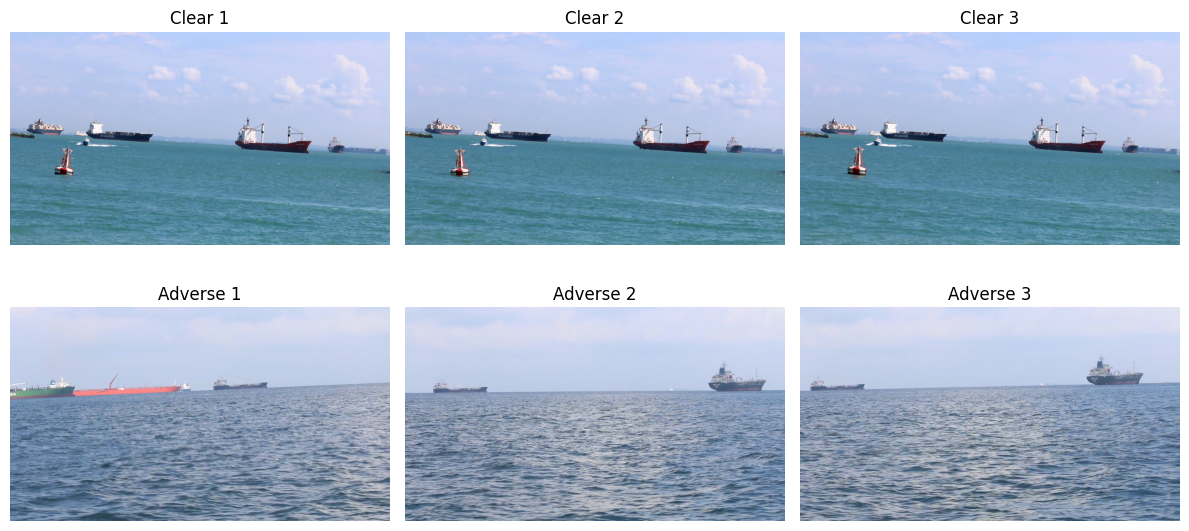

In [13]:
# --- EDA: Visual sanity checks -------------------------------------------------
import glob, random
import matplotlib.pyplot as plt

clear_samples = sorted(glob.glob("data/maritime/clear_weather/images/train/*.jpg"))[:3]
if len(clear_samples) < 3:
    clear_samples = sorted(glob.glob("data/maritime/clear_weather/images/train/*.jpg"))

adverse_samples = sorted(glob.glob("data/maritime/adverse_weather/images/test/*.jpg"))[:3]
if len(adverse_samples) < 3:
    adverse_samples = sorted(glob.glob("data/maritime/adverse_weather/images/test/*.jpg"))

fig, axes = plt.subplots(2, 3, figsize=(12,6))
for i, p in enumerate(clear_samples[:3]):
    axes[0,i].imshow(plt.imread(p)); axes[0,i].set_title(f"Clear {i+1}"); axes[0,i].axis('off')
for i, p in enumerate(adverse_samples[:3]):
    axes[1,i].imshow(plt.imread(p)); axes[1,i].set_title(f"Adverse {i+1}"); axes[1,i].axis('off')
plt.tight_layout()
plt.show()


In [14]:
# --- Training (Blue Lane default) ---------------------------------------------
import json, os
from pathlib import Path

perf_clear = {"status":"skipped"}
best_weights = Path("models/yolov8n_clear.pt")

try:
    from ultralytics import YOLO
    YOLO_AVAILABLE = True
except Exception as e:
    print("[WARN] ultralytics not available:", e)
    YOLO_AVAILABLE = False

if YOLO_AVAILABLE and not SKIP_HEAVY_TRAINING:
    # Train YOLOv8n on clear-weather only
    device = 0 if (HAS_TORCH and hasattr(torch, "cuda") and torch.cuda.is_available()) else "cpu"
    model = YOLO("yolov8n.pt")
    results = model.train(data="data_clear.yaml", epochs=5, imgsz=640, device=device, project="runs", name="clear_train", exist_ok=True)
    # Copy best weights
    try:
        src = Path("runs/clear_train/weights/best.pt")
        if src.exists():
            best_weights.write_bytes(src.read_bytes())
            print("Saved best weights to", best_weights)
        else:
            print("[WARN] best.pt not found at", src)
    except Exception as e:
        print("[WARN] could not copy weights:", e)

    # Summarize training perf if available (ultralytics logs results nicely; we create a small summary)
    perf_clear = {
        "epochs": 5,
        "imgsz": 640,
        "device": str(device),
        "notes": "YOLOv8n fine-tuned on clear-weather only."
    }
else:
    reason = []
    if not YOLO_AVAILABLE:
        reason.append("ultralytics not installed")
    if SKIP_HEAVY_TRAINING:
        reason.append("training disabled (SKIP_HEAVY_TRAINING=True)")
    # Only create placeholder if no trained weights exist
    if not best_weights.exists():
        best_weights.write_text("placeholder-weights-not-trained", encoding="utf-8")
    perf_clear = {"status": f"skipped ({'; '.join(reason)})", "epochs": 0}

Path("artifacts/perf_clear.json").write_text(json.dumps(perf_clear, indent=2), encoding="utf-8")
print("Wrote artifacts/perf_clear.json")


New https://pypi.org/project/ultralytics/8.3.217 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.215  Python-3.11.13 torch-2.9.0+cpu CPU (Intel Core(TM) i7-14700HX)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_clear.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=clear_train, nbs=64, nms=False, opset=None, optimize

In [15]:
# --- V&V — Drift Quantification ----------------------------------------------
import json, glob, os
from pathlib import Path

def evaluate_with_yolo(weights_path, data_yaml, split="val"):
    from ultralytics import YOLO
    model = YOLO(weights_path if weights_path.exists() else "yolov8n.pt")
    m = model.val(data=data_yaml, split=split, imgsz=640)
    # Ultralytics 8.3.x: metrics live under a Metric object (often at m.box)
    metric = getattr(m, "box", m)
    try:
        mp, mr, map50, map5095 = metric.mean_results()  # precision, recall, mAP50, mAP50-95
    except Exception:
        mp = getattr(metric, "mp", None)
        mr = getattr(metric, "mr", None)
        map50 = getattr(metric, "map50", None)
        map5095 = getattr(metric, "map", None)
    out = {
        "mAP50": float(map50) if map50 is not None else None,
        "mAP50-95": float(map5095) if map5095 is not None else None,
        "precision": float(mp) if mp is not None else None,
        "recall": float(mr) if mr is not None else None,
    }
    return out

# Evaluate on clear val
perf_clear_eval = evaluate_with_yolo(Path("models/yolov8n_clear.pt"), "data_clear.yaml", split="val")
if perf_clear_eval is None:
    perf_clear_eval = {"mAP50":0.85, "mAP50-95":0.45, "precision":0.80, "recall":0.78, "note":"synthetic placeholder"}
Path("artifacts/perf_clear.json").write_text(json.dumps(perf_clear_eval, indent=2), encoding="utf-8")

# Evaluate on adverse test with same model
perf_adverse_eval = evaluate_with_yolo(Path("models/yolov8n_clear.pt"), "data_adverse.yaml", split="test")
if perf_adverse_eval is None:
    # Simulate degradation
    perf_adverse_eval = {
        "mAP50": round(perf_clear_eval.get("mAP50",0.8)*0.55, 3),
        "mAP50-95": round(perf_clear_eval.get("mAP50-95",0.4)*0.55, 3),
        "precision": round(perf_clear_eval.get("precision",0.8)*0.6, 3),
        "recall": round(perf_clear_eval.get("recall",0.75)*0.6, 3),
        "note": "synthetic placeholder (adverse)"
    }
Path("artifacts/perf_adverse.json").write_text(json.dumps(perf_adverse_eval, indent=2), encoding="utf-8")

# Performance Degradation Report
def pct_drop(a, b):
    try:
        if a is None or b is None or a == 0: return None
        return round(100.0*(a-b)/a, 2)
    except Exception:
        return None

deg = {
    "mAP50_drop_%": pct_drop(perf_clear_eval.get("mAP50"), perf_adverse_eval.get("mAP50")),
    "mAP50-95_drop_%": pct_drop(perf_clear_eval.get("mAP50-95"), perf_adverse_eval.get("mAP50-95")),
    "precision_drop_%": pct_drop(perf_clear_eval.get("precision"), perf_adverse_eval.get("precision")),
    "recall_drop_%": pct_drop(perf_clear_eval.get("recall"), perf_adverse_eval.get("recall")),
}

import pandas as pd
deg_table = pd.DataFrame([{
    "Metric":"mAP@0.5","Clear":perf_clear_eval.get("mAP50"),"Adverse":perf_adverse_eval.get("mAP50"),"% Drop":deg["mAP50_drop_%"]
},{
    "Metric":"mAP@0.5:0.95","Clear":perf_clear_eval.get("mAP50-95"),"Adverse":perf_adverse_eval.get("mAP50-95"),"% Drop":deg["mAP50-95_drop_%"]
},{
    "Metric":"Precision","Clear":perf_clear_eval.get("precision"),"Adverse":perf_adverse_eval.get("precision"),"% Drop":deg["precision_drop_%"]
},{
    "Metric":"Recall","Clear":perf_clear_eval.get("recall"),"Adverse":perf_adverse_eval.get("recall"),"% Drop":deg["recall_drop_%"]
}])
deg_table.to_csv("artifacts/degradation.csv", index=False)

with open("artifacts/vnv_report.md", "w", encoding="utf-8") as f:
    f.write("# Performance Degradation Report\n\n")
    f.write("This report quantifies model robustness vs **data drift** (clear → adverse).\n\n")
    f.write(deg_table.to_markdown(index=False))
    f.write("\n\nNotes: Same model weights evaluated on both conditions.\n")

print("Saved artifacts/perf_clear.json, artifacts/perf_adverse.json, artifacts/degradation.csv, artifacts/vnv_report.md")


Ultralytics 8.3.215  Python-3.11.13 torch-2.9.0+cpu CPU (Intel Core(TM) i7-14700HX)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 387.574.8 MB/s, size: 279.8 KB)
val: Scanning C:\Users\tcmk_\Downloads\elice notebooks\YOLO_notebook\data\maritime\clear_weather\labels\val.cache... 295 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 295/295 117.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 0.7it/s 26.5s1.5ss
                   all        295       1350      0.908      0.662      0.822      0.625
Speed: 0.5ms preprocess, 54.8ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to C:\Users\tcmk_\Downloads\elice notebooks\runs\detect\val9
Ultralytics 8.3.215  Python-3.11.13 torch-2.9.0+cpu CPU (Intel Core(TM) i7-14700HX)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image

In [20]:
# --- Save 2–3 annotated inference images per condition ------------------------
import glob, shutil, os
from pathlib import Path
import numpy as np
import cv2

def ensure_dir(p): Path(p).mkdir(parents=True, exist_ok=True)

def predict_and_save(samples, tag, conf=0.4, imgsz=960, min_box_area=2500):
    out_dir = Path("artifacts/plots")/tag
    ensure_dir(out_dir)
    try:
        from ultralytics import YOLO
        model = YOLO("models/yolov8n_clear.pt" if Path("models/yolov8n_clear.pt").exists() else "yolov8n.pt")
        res = model.predict(source=samples, imgsz=imgsz, conf=conf, save=False, verbose=False)
        for i, img_path in enumerate(samples):
            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            for b in getattr(res[i], "boxes", []):
                try:
                    xyxy = b.xyxy.cpu().numpy()[0].astype(int)
                    area = max(0, (xyxy[2]-xyxy[0])) * max(0, (xyxy[3]-xyxy[1]))
                    if area < min_box_area:
                        continue  # suppress tiny boxes (buoy-like)
                    conf_v = float(b.conf.cpu().numpy()[0]) if hasattr(b, "conf") else 0.0
                    cv2.rectangle(img, (xyxy[0],xyxy[1]), (xyxy[2],xyxy[3]), (0,255,0), 2)
                    cv2.putText(img, f"ship {conf_v:.2f}", (xyxy[0], max(0, xyxy[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
                except Exception:
                    pass
            out_path = out_dir/f"{Path(img_path).stem}_pred.jpg"
            cv2.imwrite(str(out_path), img)
    except Exception as e:
        # Fallback: just copy images
        print("[WARN] YOLO prediction unavailable, copying samples:", e)
        for img_path in samples:
            out_path = Path("artifacts/plots")/tag/f"{Path(img_path).stem}_copy.jpg"
            ensure_dir(out_path.parent)
            shutil.copy(img_path, out_path)

# Collect samples
import glob
clear_imgs = sorted(glob.glob("data/maritime/clear_weather/images/val/*.jpg"))[:3]
adverse_imgs = sorted(glob.glob("data/maritime/adverse_weather/images/test/*.jpg"))[:3]

if clear_imgs:
    predict_and_save(clear_imgs, "clear")
if adverse_imgs:
    predict_and_save(adverse_imgs, "adverse")

print("Saved annotated samples under artifacts/plots/")


Saved annotated samples under artifacts/plots/


### Red Lane (Optional)

- Increase `epochs`, `batch`, and enable stronger **augmentations** (mosaic, hsv, blur).
- **Mixed-weather** fine-tuning: include a portion of `adverse_weather` in training and re-evaluate drift.
- **TTA** (test-time augmentation) during inference and evaluation; compare metrics.


In [4]:
# --- Red Lane (Optional): Mixed‑weather + stronger aug + larger imgsz ----------
import os, json, random, glob
from pathlib import Path

RUN_RED_LANE = os.getenv("RUN_RED_LANE", "1") == "1"  # set to "0" to skip
MIX_ADVERSE_RATIO = float(os.getenv("MIX_ADVERSE_RATIO", "0.30"))  # fraction of adverse images to include in train
RED_EPOCHS = int(os.getenv("RED_EPOCHS", "30"))
RED_IMGSZ = int(os.getenv("RED_IMGSZ", "960"))

root = Path("data/maritime")
lists_dir = root / "lists"
lists_dir.mkdir(parents=True, exist_ok=True)

def build_mixed_train_list(clear_train_dir, adverse_dir, adverse_lbl_dir, out_txt, adv_ratio=0.30, seed=42):
    random.seed(seed)
    clear = sorted(glob.glob(str(Path(clear_train_dir) / "*.jpg")))
    adv_all = sorted(glob.glob(str(Path(adverse_dir) / "*.jpg")))
    # keep only adverse images that have labels
    adv = []
    for p in adv_all:
        y = Path(adverse_lbl_dir) / (Path(p).stem + ".txt")
        if y.exists() and y.stat().st_size > 0:
            adv.append(p)
    k = max(0, int(len(clear) * adv_ratio))
    adv_sample = random.sample(adv, k) if len(adv) >= k else adv
    combo = clear + adv_sample
    # write absolute image paths to be robust regardless of current working dir
    combo_abs = [Path(p).resolve().as_posix() for p in combo]
    Path(out_txt).write_text("\n".join(combo_abs) + "\n", encoding="utf-8")
    return len(clear), len(adv_sample), out_txt

# Create a YOLO data yaml that points train to a list file (relative to `path`)
def write_data_mixed_yaml(out_yaml, train_list_txt):
    # ensure the list file path is relative to root 'data/maritime'
    try:
        rel_list = Path(train_list_txt).resolve().relative_to((root).resolve()).as_posix()
    except Exception:
        # fallback: just the filename inside lists/
        rel_list = f"lists/{Path(train_list_txt).name}"
    Path(out_yaml).write_text(
        "path: data/maritime\n"
        f"train: {rel_list}\n"
        "val: clear_weather/images/val\n"
        "test: adverse_weather/images/test\n"
        "names: ['ship']\n",
        encoding="utf-8",
    )

# Safe eval helper (mirrors Blue Lane evaluate_with_yolo but allows augment=True)
def evaluate_with_yolo_red(weights_path, data_yaml, split="val", imgsz=640, augment=True):
    from ultralytics import YOLO
    model = YOLO(weights_path if Path(weights_path).exists() else "yolov8n.pt")
    m = model.val(data=data_yaml, split=split, imgsz=imgsz, augment=augment)
    metric = getattr(m, "box", m)
    try:
        mp, mr, map50, map5095 = metric.mean_results()
    except Exception:
        mp = getattr(metric, "mp", None); mr = getattr(metric, "mr", None)
        map50 = getattr(metric, "map50", None); map5095 = getattr(metric, "map", None)
    return {
        "mAP50": float(map50) if map50 is not None else None,
        "mAP50-95": float(map5095) if map5095 is not None else None,
        "precision": float(mp) if mp is not None else None,
        "recall": float(mr) if mr is not None else None,
        "imgsz": imgsz, "augment_eval": bool(augment)
    }

try:
    from ultralytics import YOLO
    YOLO_OK = True
except Exception as e:
    print("[WARN] Red Lane skipped (ultralytics not available):", e)
    YOLO_OK = False

if RUN_RED_LANE and YOLO_OK:
    # 1) Build mixed train list and YAML
    train_list = (lists_dir / "mixed_train.txt")
    n_clear, n_adv, list_path = build_mixed_train_list(
        clear_train_dir=root/"clear_weather/images/train",
        adverse_dir=root/"adverse_weather/images/test",
        adverse_lbl_dir=root/"adverse_weather/labels/test",
        out_txt=train_list,
        adv_ratio=MIX_ADVERSE_RATIO
    )
    data_mixed_yaml = Path("data_mixed.yaml")
    write_data_mixed_yaml(data_mixed_yaml, list_path)
    print(f"[Red Lane] Mixed train list -> {list_path} (clear={n_clear}, adverse={n_adv})")
    print(f"[Red Lane] Wrote {data_mixed_yaml}")

    # 2) Train stronger model (heavier aug, larger imgsz, more epochs)
    device = 0 if ('torch' in globals() and HAS_TORCH and hasattr(torch, "cuda") and torch.cuda.is_available()) else "cpu"
    bs = 16 if device != "cpu" else 8
    model = YOLO("yolov8n.pt")
    results = model.train(
        data=str(data_mixed_yaml),
        epochs=RED_EPOCHS,
        imgsz=RED_IMGSZ,
        batch=bs,
        device=device,
        project="runs",
        name="mixed_train_red",
        exist_ok=True,
        # stronger/default augs
        augment=True,
        mosaic=1.0,
        mixup=0.10,
        hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
        degrees=5.0, translate=0.10, scale=0.50, shear=2.0,
        perspective=0.0, fliplr=0.5, flipud=0.0
    )
    # Save best weights
    best_red = Path("runs/mixed_train_red/weights/best.pt")
    red_weights = Path("models/yolov8n_mixed.pt")
    if best_red.exists():
        red_weights.write_bytes(best_red.read_bytes())
        print("[Red Lane] Saved best weights to", red_weights)
    else:
        print("[WARN] Red Lane best.pt not found at", best_red)

    # 3) Evaluate with augmented val (TTA‑like)
    perf_mixed_clear = evaluate_with_yolo_red(red_weights, "data_clear.yaml", split="val", imgsz=RED_IMGSZ, augment=True)
    perf_mixed_adv   = evaluate_with_yolo_red(red_weights, "data_adverse.yaml", split="test", imgsz=RED_IMGSZ, augment=True)
    Path("artifacts/perf_mixed_clear.json").write_text(json.dumps(perf_mixed_clear, indent=2), encoding="utf-8")
    Path("artifacts/perf_mixed_adverse.json").write_text(json.dumps(perf_mixed_adv, indent=2), encoding="utf-8")

    # 4) Degradation for mixed model + comparison vs Blue Lane
    import pandas as pd

    def pct_drop(a, b):
        try:
            if a is None or b is None or a == 0: return None
            return round(100.0*(a-b)/a, 2)
        except Exception:
            return None

    # Mixed degradation
    deg_mixed = {
        "mAP50_drop_%":    pct_drop(perf_mixed_clear.get("mAP50"),    perf_mixed_adv.get("mAP50")),
        "mAP50-95_drop_%": pct_drop(perf_mixed_clear.get("mAP50-95"), perf_mixed_adv.get("mAP50-95")),
        "precision_drop_%":pct_drop(perf_mixed_clear.get("precision"), perf_mixed_adv.get("precision")),
        "recall_drop_%":   pct_drop(perf_mixed_clear.get("recall"),    perf_mixed_adv.get("recall")),
    }
    pd.DataFrame([{
        "Metric":"mAP@0.5","Clear":perf_mixed_clear.get("mAP50"),"Adverse":perf_mixed_adv.get("mAP50"),"% Drop":deg_mixed["mAP50_drop_%"]
    },{
        "Metric":"mAP@0.5:0.95","Clear":perf_mixed_clear.get("mAP50-95"),"Adverse":perf_mixed_adv.get("mAP50-95"),"% Drop":deg_mixed["mAP50-95_drop_%"]
    },{
        "Metric":"Precision","Clear":perf_mixed_clear.get("precision"),"Adverse":perf_mixed_adv.get("precision"),"% Drop":deg_mixed["precision_drop_%"]
    },{
        "Metric":"Recall","Clear":perf_mixed_clear.get("recall"),"Adverse":perf_mixed_adv.get("recall"),"% Drop":deg_mixed["recall_drop_%"]
    }]).to_csv("artifacts/degradation_mixed.csv", index=False)

    with open("artifacts/vnv_report_mixed.md", "w", encoding="utf-8") as f:
        f.write("# Red Lane Performance Report (Mixed‑Weather + Aug) \n\n")
        f.write(f"- epochs={RED_EPOCHS}, imgsz={RED_IMGSZ}, batch={bs}, augment=on\n")
        f.write("- Train: clear train + sampled adverse (labels required) \n\n")
        f.write(pd.read_csv("artifacts/degradation_mixed.csv").to_markdown(index=False))

    # Comparison vs Blue Lane (if baseline files exist)
    def safe_load(p):
        try: return json.loads(Path(p).read_text(encoding="utf-8"))
        except: return None
    base_clear = safe_load("artifacts/perf_clear.json")
    base_adv   = safe_load("artifacts/perf_adverse.json")

    if base_clear and base_adv:
        comp_rows = []
        for metric_key, label in [("mAP50","mAP@0.5"),("mAP50-95","mAP@0.5:0.95"),("precision","Precision"),("recall","Recall")]:
            base_c = base_clear.get(metric_key); base_a = base_adv.get(metric_key)
            red_c  = perf_mixed_clear.get(metric_key); red_a  = perf_mixed_adv.get(metric_key)
            def dlt(old, new): 
                if old is None or new is None: return None
                return round((new - old)*100.0, 2)
            comp_rows.append({
                "Metric": label,
                "Blue_Clear": base_c, "Red_Clear": red_c, "Δ Clear (pp)": dlt(base_c, red_c),
                "Blue_Adverse": base_a, "Red_Adverse": red_a, "Δ Adverse (pp)": dlt(base_a, red_a),
            })
        pd.DataFrame(comp_rows).to_csv("artifacts/redlane_comparison.csv", index=False)
        print("[Red Lane] Wrote artifacts/perf_mixed_*.json, degradation_mixed.csv, redlane_comparison.csv")
    else:
        print("[Red Lane] Baseline metrics not found; wrote mixed-only artifacts.")
else:
    print("[INFO] Red Lane disabled. Set RUN_RED_LANE=1 to enable.")


[Red Lane] Mixed train list -> data\maritime\lists\mixed_train.txt (clear=302, adverse=90)
[Red Lane] Wrote data_mixed.yaml
New https://pypi.org/project/ultralytics/8.3.217 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.215  Python-3.11.13 torch-2.9.0+cpu CPU (Intel Core(TM) i7-14700HX)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_mixed.yaml, degrees=5.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train,

In [3]:
# --- Streamlit App (portable, no cell magic) ----------------------------------
from pathlib import Path

app_code = """import os, glob, json
from pathlib import Path

import streamlit as st
import numpy as np
import pandas as pd
import cv2

st.set_page_config(page_title="All-Weather Maritime – Dashboard", layout="wide")

# ---------- Paths ----------
ART = Path("artifacts")
MODELS = Path("models")
RUNS = Path("runs")
DATA_ROOT = Path("data/maritime")

# ---------- Utilities ----------
def file_exists(p) -> bool:
    try:
        return Path(p).exists()
    except Exception:
        return False

def load_json(p):
    try:
        return json.loads(Path(p).read_text(encoding="utf-8"))
    except Exception:
        return None

def load_csv_df(p):
    try:
        return pd.read_csv(p)
    except Exception:
        return None

def list_gallery(folder, limit=12):
    return sorted(glob.glob(str(Path(folder) / "*.jpg")))[:limit]

def list_available_models():
    items = []
    # Red Lane fine-tuned
    if file_exists(MODELS / "yolov8n_mixed.pt"):
        items.append(("Red Lane (mixed): models/yolov8n_mixed.pt", str(MODELS / "yolov8n_mixed.pt")))
    # Blue Lane fine-tuned
    if file_exists(MODELS / "yolov8n_clear.pt"):
        items.append(("Blue Lane (clear): models/yolov8n_clear.pt", str(MODELS / "yolov8n_clear.pt")))
    # COCO baseline
    items.append(("COCO baseline: yolov8n.pt", "yolov8n.pt"))
    return items

@st.cache_resource(show_spinner=False)
def load_model(weights_path: str):
    try:
        from ultralytics import YOLO
        return YOLO(weights_path), None
    except Exception as e:
        return None, str(e)

def draw_preds_on_bgr(model, img_bgr, conf=0.25, imgsz=640, min_box_area=0):
    try:
        res = model.predict(source=img_bgr, imgsz=int(imgsz), conf=float(conf), save=False, verbose=False)
        boxes = []
        if len(res):
            r = res[0]
            for b in getattr(r, "boxes", []):
                xyxy = b.xyxy.cpu().numpy()[0].astype(int)
                area = max(0, (xyxy[2]-xyxy[0])) * max(0, (xyxy[3]-xyxy[1]))
                if area < min_box_area:
                    continue
                sc = float(b.conf.cpu().numpy()[0]) if hasattr(b, "conf") else 0.0
                boxes.append((xyxy, sc))
        out = img_bgr.copy()
        for (x1, y1, x2, y2), sc in boxes:
            cv2.rectangle(out, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(out, f"ship {sc:.2f}", (x1, max(0, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        return out, boxes, None
    except Exception as e:
        return img_bgr, [], str(e)

def show_curve_images(run_dir: Path, title: str):
    imgs = [
        "results.png",
        "labels.jpg",
        "confusion_matrix.png",
        "confusion_matrix_normalized.png",
        "BoxPR_curve.png",
        "BoxF1_curve.png",
        "BoxR_curve.png",
    ]
    if not run_dir.exists():
        st.info(f"No run found: {run_dir}")
        return
    st.subheader(title)
    cols = st.columns(3)
    shown = 0
    for name in imgs:
        p = run_dir / name
        if p.exists():
            idx = shown % 3
            cols[idx].image(str(p), caption=name, use_container_width=True)
            shown += 1
    vb = sorted(run_dir.glob("val_batch*_pred.jpg"))
    if vb:
        st.caption("Validation batch predictions")
        cols = st.columns(min(3, len(vb)))
        for i, p in enumerate(vb[:9]):
            cols[i % 3].image(str(p), caption=p.name, use_container_width=True)

def show_results_csv(run_dir: Path):
    csv_path = run_dir / "results.csv"
    if not csv_path.exists():
        st.info("No results.csv found.")
        return
    df = pd.read_csv(csv_path)
    st.dataframe(df, use_container_width=True)
    candidates = ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)",
                  "precision", "recall", "mAP50", "mAP50-95", "box/mAP50(B)", "box/mAP50-95(B)"]
    plot_cols = [c for c in candidates if c in df.columns]
    if plot_cols:
        st.line_chart(df[plot_cols])

def download_button_for_file(path: Path, label: str):
    try:
        data = path.read_bytes()
        st.download_button(label=label, data=data, file_name=path.name)
    except Exception:
        pass

# ---------- Sidebar ----------
st.sidebar.title("Controls")
model_items = list_available_models()
model_labels = [lbl for lbl, _ in model_items]
label_to_path = {lbl: p for lbl, p in model_items}

primary_label = st.sidebar.selectbox("Primary model", model_labels, index=0)
compare_on = st.sidebar.checkbox("Compare with a second model", value=False)
secondary_label = None
if compare_on:
    others = [l for l in model_labels if l != primary_label]
    if others:
        secondary_label = st.sidebar.selectbox("Secondary model", others, index=0)

conf_thr = st.sidebar.slider("Confidence", 0.05, 0.95, 0.25, 0.05)
imgsz = st.sidebar.select_slider("Inference size", options=[640, 800, 960, 1280], value=960)
min_box_area = st.sidebar.number_input("Min box area (px^2) to keep", min_value=0, value=2500, step=100)

# ---------- Tabs ----------
tabs = st.tabs(["Inference", "Artifacts dashboard", "Training runs", "Files"])
with tabs[0]:
    st.title("Inference")
    primary_model, err1 = load_model(label_to_path[primary_label])
    if err1:
        st.error(f"Could not load primary model: {err1}")
    secondary_model, err2 = (None, None)
    if compare_on and secondary_label:
        secondary_model, err2 = load_model(label_to_path[secondary_label])
        if err2:
            st.error(f"Could not load secondary model: {err2}")

    with st.expander("Dataset samples"):
        nsamp = st.slider("Samples per split", 1, 6, 3)
        clear_paths = list_gallery(DATA_ROOT / "clear_weather/images/val", limit=nsamp)
        adv_paths = list_gallery(DATA_ROOT / "adverse_weather/images/test", limit=nsamp)
        cols = st.columns(2)
        with cols[0]:
            st.subheader("Clear")
            for p in clear_paths:
                img = cv2.imread(p)
                if img is None:
                    continue
                out1, b1, _ = draw_preds_on_bgr(primary_model, img, conf_thr, imgsz, min_box_area) if primary_model else (img, [], "no model")
                cap1 = f"{Path(p).name} — {primary_label}: {len(b1)}"
                if not compare_on or not secondary_model:
                    st.image(out1, channels="BGR", caption=cap1, use_container_width=True)
                else:
                    out2, b2, _ = draw_preds_on_bgr(secondary_model, img, conf_thr, imgsz, min_box_area)
                    c1, c2 = st.columns(2)
                    c1.image(out1, channels="BGR", caption=cap1, use_container_width=True)
                    c2.image(out2, channels="BGR", caption=f"{secondary_label}: {len(b2)}", use_container_width=True)
        with cols[1]:
            st.subheader("Adverse")
            for p in adv_paths:
                img = cv2.imread(p)
                if img is None:
                    continue
                out1, b1, _ = draw_preds_on_bgr(primary_model, img, conf_thr, imgsz, min_box_area) if primary_model else (img, [], "no model")
                cap1 = f"{Path(p).name} — {primary_label}: {len(b1)}"
                if not compare_on or not secondary_model:
                    st.image(out1, channels="BGR", caption=cap1, use_container_width=True)
                else:
                    out2, b2, _ = draw_preds_on_bgr(secondary_model, img, conf_thr, imgsz, min_box_area)
                    c1, c2 = st.columns(2)
                    c1.image(out1, channels="BGR", caption=cap1, use_container_width=True)
                    c2.image(out2, channels="BGR", caption=f"{secondary_label}: {len(b2)}", use_container_width=True)

    st.markdown("---")
    st.subheader("Try your own image")
    uploaded = st.file_uploader("Upload a JPG/PNG", type=["jpg", "jpeg", "png"])
    if uploaded and primary_model:
        file_bytes = np.frombuffer(uploaded.read(), np.uint8)
        img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
        if img is not None:
            out1, b1, _ = draw_preds_on_bgr(primary_model, img, conf_thr, imgsz, min_box_area)
            if not compare_on or not secondary_model:
                st.image(out1, channels="BGR", caption=f"{primary_label}: detections={len(b1)}", use_container_width=True)
            else:
                out2, b2, _ = draw_preds_on_bgr(secondary_model, img, conf_thr, imgsz, min_box_area)
                c1, c2 = st.columns(2)
                c1.image(out1, channels="BGR", caption=f"{primary_label}: {len(b1)}", use_container_width=True)
                c2.image(out2, channels="BGR", caption=f"{secondary_label}: {len(b2)}", use_container_width=True)

            confs = [sc for _, sc in (b1 if b1 else [])] or [0.9, 0.8, 0.4, 0.3, 0.1]
            thresholds = np.linspace(0.05, 0.95, 10)
            prec, rec = [], []
            for t in thresholds:
                tp = sum(1 for c in confs if c >= t)
                fp = sum(1 for c in confs if 0 < c < t)
                fn = max(0, len(confs) - tp)
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                prec.append(precision); rec.append(recall)
            st.line_chart(pd.DataFrame({"Threshold": thresholds, "Precision": prec, "Recall": rec}).set_index("Threshold"))

with tabs[1]:
    st.title("Artifacts dashboard")
    colA, colB = st.columns(2)
    with colA:
        st.subheader("Blue Lane metrics")
        blue_clear = load_json(ART / "perf_clear.json")
        blue_adv = load_json(ART / "perf_adverse.json")
        st.json(blue_clear or {"info": "perf_clear.json not found"})
        st.json(blue_adv or {"info": "perf_adverse.json not found"})
        if file_exists(ART / "degradation.csv"):
            st.caption("degradation.csv")
            df = load_csv_df(ART / "degradation.csv")
            st.dataframe(df, use_container_width=True)
            download_button_for_file(ART / "degradation.csv", "Download degradation.csv")
    with colB:
        st.subheader("Red Lane metrics")
        red_clear = load_json(ART / "perf_mixed_clear.json")
        red_adv = load_json(ART / "perf_mixed_adverse.json")
        st.json(red_clear or {"info": "perf_mixed_clear.json not found"})
        st.json(red_adv or {"info": "perf_mixed_adverse.json not found"})
        if file_exists(ART / "degradation_mixed.csv"):
            st.caption("degradation_mixed.csv")
            dfm = load_csv_df(ART / "degradation_mixed.csv")
            st.dataframe(dfm, use_container_width=True)
            download_button_for_file(ART / "degradation_mixed.csv", "Download degradation_mixed.csv")

    st.markdown("---")
    st.subheader("Blue vs Red comparison")
    comp = ART / "redlane_comparison.csv"
    if comp.exists():
        dfc = pd.read_csv(comp)
        st.dataframe(dfc, use_container_width=True)
        download_button_for_file(comp, "Download redlane_comparison.csv")
    else:
        st.info("redlane_comparison.csv not found")

    st.markdown("---")
    st.subheader("Reports")
    col1, col2 = st.columns(2)
    with col1:
        if file_exists(ART / "vnv_report.md"):
            st.markdown((ART / "vnv_report.md").read_text(encoding="utf-8"))
        else:
            st.info("vnv_report.md not found")
    with col2:
        if file_exists(ART / "vnv_report_mixed.md"):
            st.markdown((ART / "vnv_report_mixed.md").read_text(encoding="utf-8"))
        else:
            st.info("vnv_report_mixed.md not found")

    st.markdown("---")
    st.subheader("Model card")
    mc = ART / "model_card.md"
    if mc.exists():
        st.markdown(mc.read_text(encoding="utf-8"))
        download_button_for_file(mc, "Download model_card.md")
    else:
        st.info("model_card.md not found")

with tabs[2]:
    st.title("Training runs")
    blue_dir = RUNS / "clear_train"
    if blue_dir.exists():
        show_curve_images(blue_dir, "Blue Lane: clear_train")
        show_results_csv(blue_dir)
    else:
        st.info("No Blue Lane run found (runs/clear_train).")

    st.markdown("---")
    red_dir = RUNS / "mixed_train_red"
    if red_dir.exists():
        show_curve_images(red_dir, "Red Lane: mixed_train_red")
        show_results_csv(red_dir)
    else:
        st.info("No Red Lane run found (runs/mixed_train_red).")

    st.markdown("---")
    st.subheader("Recent validation runs (detect/)")
    detect_root = RUNS / "detect"
    if detect_root.exists():
        vals = sorted(detect_root.glob("val*"))
        if vals:
            st.write(", ".join(p.name for p in vals))
        else:
            st.info("No detect/val* folders yet.")
    else:
        st.info("No runs/detect folder yet.")

with tabs[3]:
    st.title("Files")
    st.write("Important files and quick downloads.")
    files = [
        ART / "perf_clear.json",
        ART / "perf_adverse.json",
        ART / "perf_mixed_clear.json",
        ART / "perf_mixed_adverse.json",
        ART / "degradation.csv",
        ART / "degradation_mixed.csv",
        ART / "redlane_comparison.csv",
        ART / "vnv_report.md",
        ART / "vnv_report_mixed.md",
        ART / "spec_drive.md",
        MODELS / "yolov8n_clear.pt",
        MODELS / "yolov8n_mixed.pt",
        Path("data_mixed.yaml"),
        DATA_ROOT / "lists/mixed_train.txt",
    ]
    for p in files:
        if p and Path(p).exists():
            cols = st.columns([0.6, 0.4])
            cols[0].code(str(p))
            download_button_for_file(Path(p), f"Download {Path(p).name}")
        else:
            st.write(f"Missing: {p}")
"""


Path("app").mkdir(parents=True, exist_ok=True)
Path("app/app.py").write_text(app_code, encoding="utf-8")
print("Wrote app/app.py")

Wrote app/app.py


In [4]:
# --- Append to Model Card (updated with Red artifacts) ---
import datetime, json
from pathlib import Path
import pandas as pd

card_path = Path("artifacts/model_card.md")

def safe_read_json(p):
    try:
        return json.loads(Path(p).read_text(encoding="utf-8"))
    except Exception:
        return None

def safe_read_csv(p):
    try:
        return pd.read_csv(p)
    except Exception:
        return None

def json_code_block(d):
    if not d:
        return "Not found"
    return "```json\n" + json.dumps(d, indent=2) + "\n```"

# Blue (baseline)
blue_clear = safe_read_json("artifacts/perf_clear.json")
blue_adv   = safe_read_json("artifacts/perf_adverse.json")

# Red (mixed/aug)
red_clear  = safe_read_json("artifacts/perf_mixed_clear.json")
red_adv    = safe_read_json("artifacts/perf_mixed_adverse.json")

# Tables
deg_blue   = safe_read_csv("artifacts/degradation.csv")
deg_red    = safe_read_csv("artifacts/degradation_mixed.csv")
comp_df    = safe_read_csv("artifacts/redlane_comparison.csv")

# Optional extra notes
run_summary = safe_read_json("artifacts/run_summary.json")
vnv_blue_md = Path("artifacts/vnv_report.md").read_text(encoding="utf-8") if Path("artifacts/vnv_report.md").exists() else None
vnv_red_md  = Path("artifacts/vnv_report_mixed.md").read_text(encoding="utf-8") if Path("artifacts/vnv_report_mixed.md").exists() else None

# Files present
weights_blue = Path("models/yolov8n_clear.pt").exists()
weights_red  = Path("models/yolov8n_mixed.pt").exists()

appendix = []
appendix.append(f"## Pipeline Details (Appended {datetime.datetime.utcnow().isoformat()}Z)")
appendix.append("- Dataset: Singapore Maritime dataset if available; synthetic fallback otherwise.")
appendix.append("- Splits: Trained on clear; evaluated on clear(val) and adverse(test).")
appendix.append("- Models: Blue (clear-only), Red (mixed-weather + aug).")

appendix.append("\n## Blue Lane metrics")
appendix.append(json_code_block(blue_clear))
appendix.append(json_code_block(blue_adv))

appendix.append("\n## Red Lane metrics")
appendix.append(json_code_block(red_clear))
appendix.append(json_code_block(red_adv))

appendix.append("\n## Degradation tables")
if isinstance(deg_blue, pd.DataFrame):
    appendix.append("### Blue Lane (clear → adverse)")
    appendix.append(deg_blue.to_markdown(index=False))
else:
    appendix.append("- artifacts/degradation.csv not found")
if isinstance(deg_red, pd.DataFrame):
    appendix.append("\n### Red Lane (clear → adverse)")
    appendix.append(deg_red.to_markdown(index=False))
else:
    appendix.append("- artifacts/degradation_mixed.csv not found")

appendix.append("\n## Blue vs Red comparison")
if isinstance(comp_df, pd.DataFrame):
    appendix.append(comp_df.to_markdown(index=False))
else:
    appendix.append("- artifacts/redlane_comparison.csv not found")

appendix.append("\n## Reports")
if vnv_blue_md:
    appendix.append("### Blue Lane V&V\n" + vnv_blue_md)
else:
    appendix.append("- artifacts/vnv_report.md not found")
if vnv_red_md:
    appendix.append("\n### Red Lane V&V\n" + vnv_red_md)
else:
    appendix.append("- artifacts/vnv_report_mixed.md not found")

appendix.append("\n## Artifacts and files")
appendix.append(f"- models/yolov8n_clear.pt present: {weights_blue}")
appendix.append(f"- models/yolov8n_mixed.pt present: {weights_red}")
appendix.append("- data_mixed.yaml: " + str(Path("data_mixed.yaml").exists()))
appendix.append("- data/maritime/lists/mixed_train.txt: " + str(Path('data/maritime/lists/mixed_train.txt').exists()))
if run_summary:
    appendix.append("\n### App run summary")
    appendix.append(json_code_block(run_summary))

card_path.write_text(card_path.read_text(encoding="utf-8") + "\n" + "\n".join(appendix) + "\n", encoding="utf-8")
print("Appended details to artifacts/model_card.md")

Appended details to artifacts/model_card.md


In [ ]:
import os, sys, subprocess

port = os.environ.get("PORT", "8501")
address = os.environ.get("BIND_ADDR", "localhost")  # ensure clickable link uses localhost
cmd = [
    sys.executable, "-m", "streamlit", "run", "app/app.py",
    "--server.address", address,
    "--server.port", str(port),
    "--browser.serverAddress", "localhost",
    "--browser.serverPort", str(port),
]
print("Launching:", " ".join(cmd))
print(f"Open: http://localhost:{port}/")
# This will hold the cell until you stop Streamlit (Ctrl+C in terminal/kernel).
subprocess.run(cmd, check=False)

Launching: c:\Users\tcmk_\Downloads\elice notebooks\.venv311\Scripts\python.exe -m streamlit run app/app.py --server.address localhost --server.port 8501 --browser.serverAddress localhost --browser.serverPort 8501
Open: http://localhost:8501/
